# Deflection Profile Parametric Study
This notebook presents a parametric study based on the Deflection-Profile implementation provided in the file "deflection_profile.py" of the bmcs_beam package.

In [1]:
%matplotlib inline

In [2]:
from bmcs_cross_section.mkappa import MKappa
from bmcs_beam.beam_config.boundary_conditions import BoundaryConditions
from bmcs_beam.bending.deflection_profile import DeflectionProfile
from bmcs_beam.beam_config.beam_design import BeamDesign
from bmcs_cross_section.cs_design.cs_shape import TShape
from os.path import join
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import bmcs_utils.api as bu

In [12]:
def map_and_assign_params_for_rectangular_section(
        mc, # MKappa instance for which the params should be applied
        b, h, E, E_s, f_sy, eps_cr, rho, beta_tu, v_f, omega, psi, mu, alpha, lambda_cu):
    """This function map the params of the rectangular section from the type of the paper
    to the type of the model and assigns the values"""
    mc.cross_section_shape.B=b
    mc.cross_section_shape.H=h
    mc.E_cc=E
    mc.E_ct=E 
    mc.mu=mu
    mc.eps_cr=eps_cr
    mc.eps_cy=omega * eps_cr
    mc.eps_cu=lambda_cu * eps_cr
    mc.eps_tu=beta_tu * eps_cr
    mc.eps_sy_j=[f_sy / E_s] # or eps_sy_j=psi * eps_cr,
    mc.E_j=[E_s]
    mc.z_j=[h * (1 - alpha)]
    mc.A_j=[rho * b * h]

#### 1. Verification with Heid et al. (2020), [link](https://www.heringinternational.com/fileadmin/media/archive1/downloads/architekturbeton/Bauingenieur_06_2020_S.210-219.pdf), Carbon reinforcement

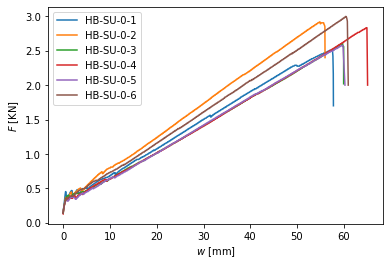

In [4]:
#HB-SU-0
%matplotlib inline
excel_file = join('./verification_data/hei20','hei20.xlsx')
data = pd.read_excel(excel_file, 'HB-SU-0')

for i in range(0,data.shape[1],2):
    plt.plot(data.iloc[:, i+1],data.iloc[:, i], label = data.columns.tolist()[i][0:-2])
w_4= data['HB-SU-0-4_w']  ; f_4= data['HB-SU-0-4_F'] ; validated_data = [w_4, f_4/4]; #plt.plot(w_4,f_4, label = 'HB-SU-0-4')
plt.legend(); plt.xlabel(r'$w$ [mm]'); plt.ylabel(r'$F$ [KN]');

In [5]:
def get_parametric_study(parameter_ranges, validated_data):
    
    np.set_printoptions(precision=3)
    if np.ceil(len(parameter_ranges)/3).astype('int') == 1:
        nrows = np.ceil(len(parameter_ranges)/3).astype('int') + 1
    else:
        nrows = np.ceil(len(parameter_ranges)/3).astype('int')
    ncols= 3

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7 * ncols, 5 * nrows))
    col = 0
    row = 0

    for i, ax in enumerate(axes.flatten()):
        w_val = validated_data[0]
        f_val = validated_data[1]
        ax.plot(w_val, f_val, c= 'black', label= 'Experiment', linestyle='--')
        
    for param_name, param_range in parameter_ranges.items():

        mc = MKappa(n_m=100, n_kappa = 100)
        dp = DeflectionProfile(mc=mc)
        dp.mc.low_kappa = 0
        dp.mc.high_kappa = 0.0008
        # Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
        dp.beam_design.beam_conf_name = BoundaryConditions.CONFIG_NAMES[1]
        dp.beam_design.L = 3 * 320
        map_and_assign_params_for_rectangular_section(dp.mc,
                    beta_tu = 2,  #  eps_tu/eps_cr
                    b = 45,
                    h = 30,
                    rho = 7.24/30/150/2,
                    v_f = 1.0,
                    E = 39500,
                    E_s = 240000, 
                    f_sy = 2712 , 
                    eps_cr = 0.000163, 
                    omega = .68, #eps_cy/eps_cr
                    psi = 0.0113/0.00016, #eps_sy_j/eps_cr
                    mu = .2, #σp/σcr
                    alpha = 0.75, #z_j/h
                    lambda_cu = 0.11/0.00016) #eps_cu/eps_cr
        dp.mc.A_j = np.array([3.62, 3.62])  # A_j[0] for tension steel / A_j[1] for compression steel
        dp.mc.z_j = np.array([8, 22])
        dp.mc.E_j = np.array([240000, 240000])
        dp.mc.eps_sy_j = np.array([0.0113, 0.0113])
        
        if param_name == 'L':
            for value in np.linspace(*param_range):
                setattr(dp.beam_design, param_name, value)
                dp.plot_fw_par(axes[row, col], param_name, value)
        elif param_name == 'B':
            for value in np.linspace(*param_range):
                setattr(dp.mc.cross_section_shape, param_name, value)
                dp.plot_fw_par(axes[row, col], param_name, value)
        else:
            for value in np.linspace(*param_range):
                setattr(dp.mc, param_name, value)
                dp.plot_fw_par(axes[row, col], param_name, value)
                print(dp.mc.E_cc)
        if col < ncols - 1  :
            col +=1
        else:
            row += 1
            col = 0

In [6]:
def get_parametric_study(parameter_ranges, validated_data):
    # not Ann
    np.set_printoptions(precision=3)
    if np.ceil(len(parameter_ranges)/3).astype('int') == 1:
        nrows = np.ceil(len(parameter_ranges)/3).astype('int') + 1
    else:
        nrows = np.ceil(len(parameter_ranges)/3).astype('int')
    ncols= 3

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7 * ncols, 5 * nrows))
    col = 0
    row = 0

    for i, ax in enumerate(axes.flatten()):
        w_val = validated_data[0]
        f_val = validated_data[1]
#         ax.plot(w_val, f_val, c= 'black', label= 'Experiment', linestyle='--')
        
    for param_name, param_range in parameter_ranges.items():

        mc = MKappa(n_m=100, n_kappa = 100)
        dp = DeflectionProfile(mc=mc)
        dp.mc.low_kappa = 0
        dp.mc.high_kappa = 0.00008

        # Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
        dp.beam_design.beam_conf_name = BoundaryConditions.CONFIG_NAMES[1]

        dp.beam_design.L = 3 * 650

        map_and_assign_params_for_rectangular_section(dp.mc,
                    beta_tu = 2,  #  eps_tu/eps_cr
                    b = 150,
                    h = 100,
                    rho = (0.0079 * 2 * 150 * 12) / (150 * 88),
                    v_f = 0.0,
                    E = 30000,
                    E_s = 225000, 
                    f_sy = 3350 , 
                    eps_cr = 0.00016, # how to calculate it?! 
                    omega = .68, #eps_cy/eps_cr
                    psi = 0.0148/0.00016, #eps_sy_j/eps_cr
                    mu = 0.2, #σp/σcr
                    alpha = .94, #z_j/h
                    lambda_cu = 21.93) #eps_cu/eps_cr

        if param_name == 'L':
            for value in np.linspace(*param_range):
                setattr(dp.beam_design, param_name, value)
                dp.plot_fw_par(axes[row, col], param_name, value)
        elif param_name == 'B':
            for value in np.linspace(*param_range):
                setattr(dp.mc.cross_section_shape, param_name, value)
                dp.plot_fw_par(axes[row, col], param_name, value)
        else:
            for value in np.linspace(*param_range):
                setattr(dp.mc, param_name, value)
                dp.plot_fw_par(axes[row, col], param_name, value)
                print(dp.mc.E_cc)
                dp.mc.plot_mk_and_stress_profile(axes[row, col +1], axes[row , col +2])
        if col < ncols - 1  :
            col +=1
        else:
            row += 1
            col = 0

In [7]:
# This dictionary provides the range and number of parameters
n = 1
parameter_ranges = {
#         'L' : (660,1260,n),
#         'B' : (150,15,n),
#         'H': (25,35,n),
#         'E_ct': (10000,70000,n),
        'E_cc': (0,40000,n),
#         'eps_cr': (0.00005,0.0002,n),
#         'eps_cy': (-0.003,-0.004,n),
#         'eps_cu': (0.001,0.01,n,int),
#         'eps_tu': (0.001,0.006,3),
#         'mu': (0,1,n),
#         'z_j': ((0, 30),(15, 15),n),
#         'A_j': ((2.62,2.62),(4.2,4.2),n),
#         'E_j': ((240000,240000),(280000,280000), n),
#         'eps_sy_j' : ((0.0113,0.0113), (0.009,0.009), n),
#         'n_m' : (2, 1000, 10)
    }

# ps = get_parametric_study(parameter_ranges, validated_data)
# ps

In [13]:
import bmcs_utils.api as bu
%matplotlib widget

mc = MKappa(n_m=100, n_kappa = 100)
dp = DeflectionProfile(mc=mc)
dp.mc.low_kappa = 0
dp.mc.high_kappa = 0.00008

# Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
dp.beam_design.beam_conf_name = BoundaryConditions.CONFIG_NAMES[1]

dp.beam_design.L = 3 * 650

map_and_assign_params_for_rectangular_section(dp.mc,
    beta_tu = 2,  #  eps_tu/eps_cr
    b = 150,
    h = 100,
    rho = (0.0079 * 2 * 150 * 12) / (150 * 88),
    v_f = 0.0,
    E = 30000,
    E_s = 225000, 
    f_sy = 3350 , 
    eps_cr = 0.00016, # how to calculate it?! 
    omega = .68, #eps_cy/eps_cr
    psi = 0.0148/0.00016, #eps_sy_j/eps_cr
    mu = 0.2, #σp/σcr
    alpha = .94, #z_j/h
    lambda_cu = 21.93) #eps_cu/eps_cr

print(dp.mc.cross_section_layout.matrix.E_cc)
print(dp.mc.E_cc)
dp.mc.E_cc= 0
print(dp.mc.cross_section_layout.matrix.E_cc)
print(dp.mc.E_cc)

bu.InteractiveWindow([dp, 
                      dp.beam_design, 
                      dp.mc, 
                      dp.mc.cs_design.cross_section_shape, 
                      dp.mc.cs_design.cross_section_layout], tight_layout=True).interact()

30000.0
30000.0
0.0
0.0
